**Dataframe used:** From stats Canada, Volumes by trade

**Title:** Covid's Impact on Trade in Canada: a Regression Dscontinuity Approach

**Objective:** The main goal of my project is to examine the influence of COVID-19 on Canada's import and export volumes. To achieve this, I adopted a Regression Discontinuity Approach. This methodology is particularly suitable because it allows us to capture abrupt changes in data patterns around a specific threshold—in our case, the onset of the pandemic.

As for predictions models I went with a TimeSeries approach Auto Arima and LSTM Models.

In [1]:
#Cell already ran
!pip install pmdarima

In [2]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import pmdarima as pm

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#keras
from keras.models import Sequential
import keras.models
import tensorflow

In [6]:
df = pd.read_csv('1210001101_databaseLoadingData.csv')
df

,REF_DATE,GEO,DGUID,Trade,Basis,Seasonal adjustment,Principal trading partners,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1997-01,Canada,2016A000011124,Import,Balance of payments,Seasonally adjusted,All countries,Dollars,81,millions,6,v87008839,1.1.2.2.1,21837.7,NaN,NaN,NaN,1
1,1997-02,Canada,2016A000011124,Import,Balance of payments,Seasonally adjusted,All countries,Dollars,81,millions,6,v87008839,1.1.2.2.1,21755.0,NaN,NaN,NaN,1
2,1997-03,Canada,2016A000011124,Import,Balance of payments,Seasonally adjusted,All countries,Dollars,81,millions,6,v87008839,1.1.2.2.1,21839.5,NaN,NaN,NaN,1
3,1997-04,Canada,2016A000011124,Import,Balance of payments,Seasonally adjusted,All countries,Dollars,81,millions,6,v87008839,1.1.2.2.1,22620.9,NaN,NaN,NaN,1
4,1997-05,Canada,2016A000011124,Import,Balance of payments,Seasonally adjusted,All countries,Dollars,81,millions,6,v87008839,1.1.2.2.1,22747.5,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,2023-02,Canada,2016A000011124,Trade Balance,Balance of payments,Seasonally adjusted,Mexico,Dollars,81,millions,6,v87008995,1.3.2.2.12,-1386.8,NaN,NaN,NaN,1
5720,2023-03,Canada,2016A000011124,Trade Balance,Balance of payments,Seasonally adjusted,Mexico,Dollars,81,millions,6,v87008995,1.3.2.2.12,-1471.1,NaN,NaN,NaN,1
5721,2023-04,Canada,2016A000011124,Trade Balance,Balance of payments,Seasonally adjusted,Mexico,Dollars,81,millions,6,v87008995,1.3.2.2.12,-1515.2,NaN,NaN,NaN,1
5722,2023-05,Canada,2016A000011124,Trade Balance,Balance of payments,Seasonally adjusted,Mexico,Dollars,81,millions,6,v87008995,1.3.2.2.12,-1497.2,NaN,NaN,NaN,1


In [65]:
#verifying unique countries 
df['Principal trading partners'].unique()

array(['All countries', 'United States', 'European Union', 'China',
       'United Kingdom', 'Mexico'], dtype=object)

In [7]:
#formatting to date time
df ['DATE_FORMATTED'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m-%d')

Dropping all values that do not contribute significant values to any of my analisys , values that only have 1 category mainly.

In [8]:
df.drop(['GEO','DGUID','Basis','SCALAR_FACTOR',"SCALAR_ID",'VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS'], axis =1, inplace =True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   REF_DATE                    5724 non-null   object        
 1   Trade                       5724 non-null   object        
 2   Seasonal adjustment         5724 non-null   object        
 3   Principal trading partners  5724 non-null   object        
 4   UOM                         5724 non-null   object        
 5   UOM_ID                      5724 non-null   int64         
 6   VALUE                       5724 non-null   float64       
 7   DATE_FORMATTED              5724 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 357.9+ KB


**Let's start vizualizing**

In the below plot I realized I needed to split Import and Export Values to see the information represented in a better and cleaner way

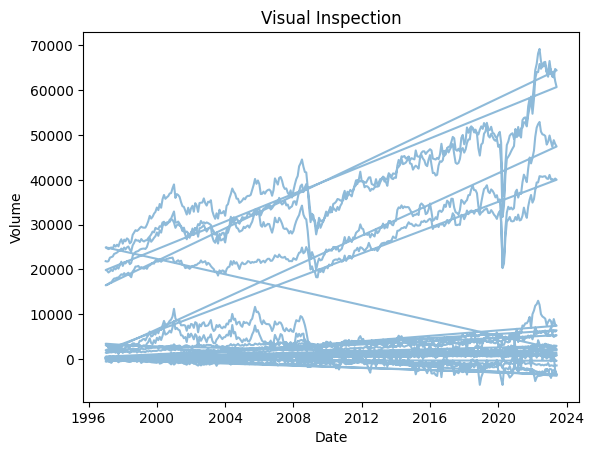

In [10]:
#plotting  Date vs Value


plt.plot(df ['DATE_FORMATTED'],df ['VALUE'], alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Visual Inspection')
plt.show()

Now that I separate Export and Import , I use "Hue" to separate my trades in the graph :)

<Axes: xlabel='DATE_FORMATTED', ylabel='VALUE'>

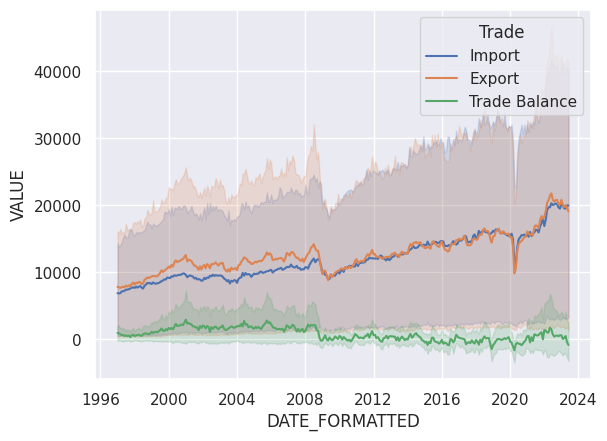

In [11]:
#plotting

import seaborn as sns
sns.set()
sns.lineplot(x='DATE_FORMATTED', y="VALUE", hue="Trade", data=df)

Realized I will need to separate by Import and Export to do the Regression Discontinuity analysis.

After this I am dividing the Value by its mean to normalize the numbers.

In [12]:
df['Value_Mean'] = df['VALUE'] / df['VALUE'].mean()
df['Value_Mean']

0       2.564317
1       2.554606
2       2.564528
3       2.656285
4       2.671151
          ...   
5719   -0.162847
5720   -0.172746
5721   -0.177924
5722   -0.175810
5723   -0.169340
Name: Value_Mean, Length: 5724, dtype: float64

<Axes: xlabel='DATE_FORMATTED', ylabel='Value_Mean'>

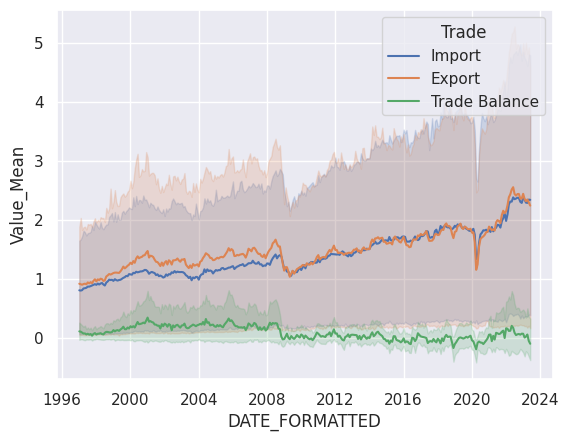

In [13]:
#plotting with Value normalized

sns.set()
sns.lineplot(x='DATE_FORMATTED', y="Value_Mean", hue="Trade", data=df)

Trying a function to automate the RDD for both import and export :

In [14]:
def rdd_analysis(df, trade_type, event_date, advance, left_side, right_side):
    # Subset the data based on trade type and conditions
    trade_df = df[(df['Trade'] == trade_type) & (df['Principal trading partners'] == 'All countries')]

    # Adding a 'month' column
    trade_df['month'] = trade_df.index

    # Calculate cutoff date
    cutoff_date = trade_df.loc[trade_df.DATE_FORMATTED == event_date].index.to_list()[0] + advance

    # Create the dataframe for the event
    rdd_data = trade_df.loc[(trade_df['month'] >= (cutoff_date - left_side)) & (trade_df['month'] <= (cutoff_date + right_side))]

    # Store positive and negative sides
    rdd_data['month'] -= cutoff_date

    # Add a column for the threshold
    rdd_data['test'] = np.where(rdd_data.month < 0, 0, 1)

    rdd_data['Cutoff'] = np.where(rdd_data.test <= 0, "Before", "After")

    # Creating the RDD model
    rdd_event = rdd_data.assign(threshold=(rdd_data["month"] > 0).astype(int))

    # Creating the formula for the linear regression model
    formula = 'VALUE ~ month + test + month*test'

    # Obtaining the stat model
    rdd_model = smf.wls(formula=formula, data=rdd_event).fit()

    # Printing model summary
    print('Here is the result of your model!')
    print('Here is the r-squared value of your model:', rdd_model.rsquared)
    print(rdd_model.summary().tables[1])

    # Plotting the RDD graph
    sns.lmplot(data=rdd_event, x="month", y="VALUE", hue="Cutoff", ci=85, legend='full', legend_out=True)

    # Adding Details to the Graph
    plt.axvline(x=0, color='g', linestyle='--')
    plt.xlabel('Months before and after the event')
    plt.ylabel('Number of Trades')
    plt.legend([trade_type, 'Fitted Line'])
    plt.grid()
    plt.tight_layout()
    plt.show()

<ipython-input-14-64a03e30f429>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_df['month'] = trade_df.index
<ipython-input-14-64a03e30f429>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data['month'] -= cutoff_date
<ipython-input-14-64a03e30f429>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Here is the result of your model!
Here is the r-squared value of your model: 0.8011825291960033
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.668e+04   1403.809     33.256      0.000    4.39e+04    4.95e+04
month       -178.0982     98.246     -1.813      0.077    -375.976      19.780
test        4005.2642   1908.990      2.098      0.042     160.361    7850.168
month:test   892.6532    134.874      6.618      0.000     621.004    1164.303


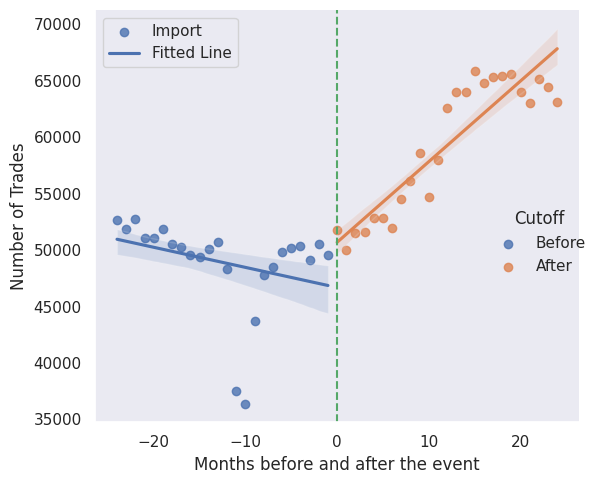

None
Here is the result of your model!
Here is the r-squared value of your model: 0.7949672755471698
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.408e+04   1748.926     25.203      0.000    4.06e+04    4.76e+04
month       -218.6859    122.399     -1.787      0.081    -465.211      27.839
test        7264.7006   2378.301      3.055      0.004    2474.556    1.21e+04
month:test   964.9419    168.031      5.743      0.000     626.509    1303.374


<ipython-input-14-64a03e30f429>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_df['month'] = trade_df.index
<ipython-input-14-64a03e30f429>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data['month'] -= cutoff_date
<ipython-input-14-64a03e30f429>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

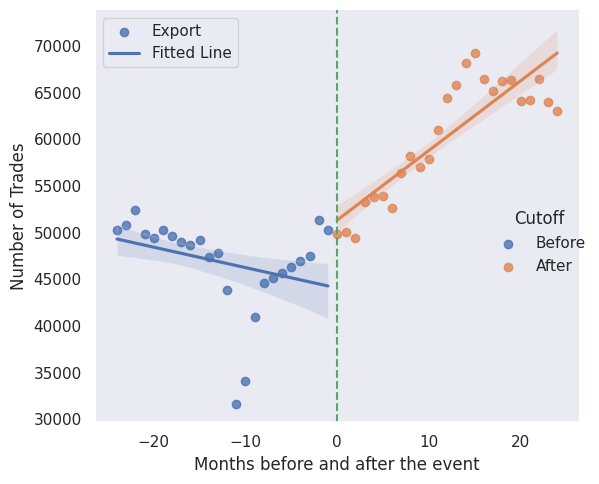

None


In [15]:
# Example usage
event_date = '2020-03-01'
advance = 12
left_side = 24
right_side = 24

# Assuming you have a DataFrame named 'df'
print(rdd_analysis(df, trade_type='Import', event_date=event_date, advance=advance, left_side=left_side, right_side=right_side))
print(rdd_analysis(df, trade_type='Export', event_date=event_date, advance=advance, left_side=left_side, right_side=right_side))

**Visual Representation of Export and Import Trends**
As you can see in the graphs on this slide, the actual data points, the fitted trend lines, and the discontinuity point (March 1st, 2020) are visually evident for both export and import volumes.


**Interpreting the Coefficients**
Delving into the coefficients:
* The intercept sets the base volume before any changes.
* The non-significant month coefficient suggests no gradual trend shift.
* The significant test coefficient implies a substantial post-pandemic increase in volumes.
* The interaction coefficient highlights an intensified effect over time due to the pandemic's impact.


**What can we gather from these coefficients?**
The pandemic led to a substantial increase in both export and import volumes. This might be attributed to various factors such as adapting trade strategies to new norms, evolving global demand patterns, and more.

In conclusion, this Regression Discontinuity Analysis provides valuable insights. COVID-19 triggered a significant increase in both import and export volumes. 

Let's dive into the..

# Time Series Model

In [16]:
#Plotting
df.head()

,REF_DATE,Trade,Seasonal adjustment,Principal trading partners,UOM,UOM_ID,VALUE,DATE_FORMATTED,Value_Mean
0,1997-01,Import,Seasonally adjusted,All countries,Dollars,81,21837.7,1997-01-01,2.564317
1,1997-02,Import,Seasonally adjusted,All countries,Dollars,81,21755.0,1997-02-01,2.554606
2,1997-03,Import,Seasonally adjusted,All countries,Dollars,81,21839.5,1997-03-01,2.564528
3,1997-04,Import,Seasonally adjusted,All countries,Dollars,81,22620.9,1997-04-01,2.656285
4,1997-05,Import,Seasonally adjusted,All countries,Dollars,81,22747.5,1997-05-01,2.671151


In [17]:
#The well kow preprocessing of this type of data for TimeSeries Auto Arima

test1 = df.set_index('DATE_FORMATTED')
test1.drop(['REF_DATE'], axis=1, inplace = True)
test1.resample('MS').sum()# Specifies the index frequency as month-start
test1

<ipython-input-17-64518ba16116>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test1.resample('MS').sum()# Specifies the index frequency as month-start


,Trade,Seasonal adjustment,Principal trading partners,UOM,UOM_ID,VALUE,Value_Mean
DATE_FORMATTED,,,,,,,
1997-01-01,Import,Seasonally adjusted,All countries,Dollars,81,21837.7,2.564317
1997-02-01,Import,Seasonally adjusted,All countries,Dollars,81,21755.0,2.554606
1997-03-01,Import,Seasonally adjusted,All countries,Dollars,81,21839.5,2.564528
1997-04-01,Import,Seasonally adjusted,All countries,Dollars,81,22620.9,2.656285
1997-05-01,Import,Seasonally adjusted,All countries,Dollars,81,22747.5,2.671151
...,...,...,...,...,...,...,...
2023-02-01,Trade Balance,Seasonally adjusted,Mexico,Dollars,81,-1386.8,-0.162847
2023-03-01,Trade Balance,Seasonally adjusted,Mexico,Dollars,81,-1471.1,-0.172746
2023-04-01,Trade Balance,Seasonally adjusted,Mexico,Dollars,81,-1515.2,-0.177924


It's important to determine for the autoarima model what kind of value **stationary or no passing into the model**

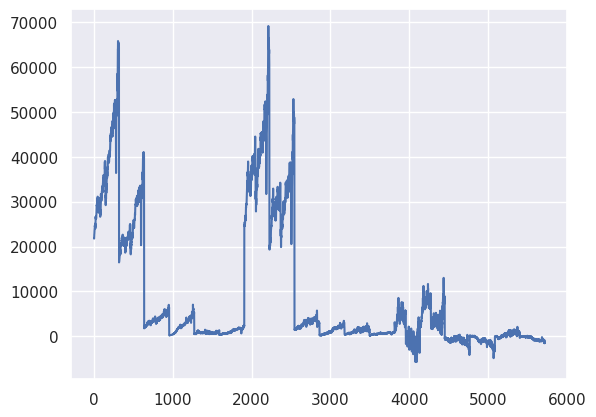

In [18]:
timeseries = df[["VALUE"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

**Barplot to find any correlation for Time Series Model:**

The take on the below plots is that since 1997 Trade volumes are very similar to each other , as well as we can see that volumes are much higher of trades between Canada and Unites states , which would make sense considering we are border countries. 

the rest o fht evalues have been dropped are they do not add much to this model 

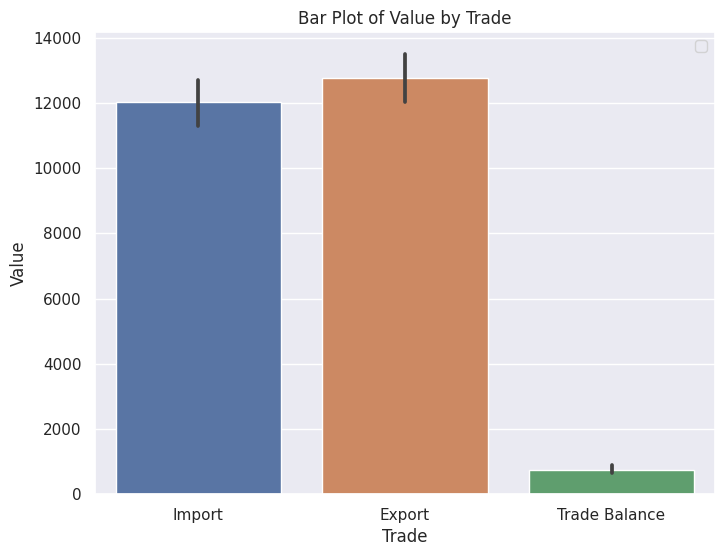

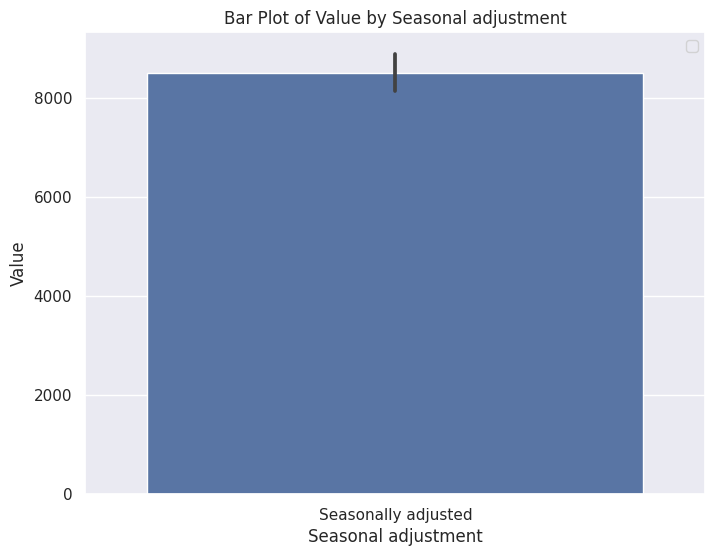

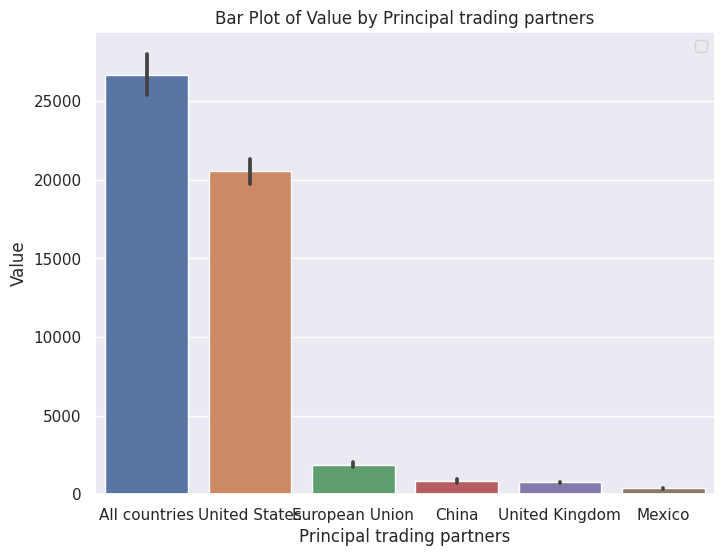

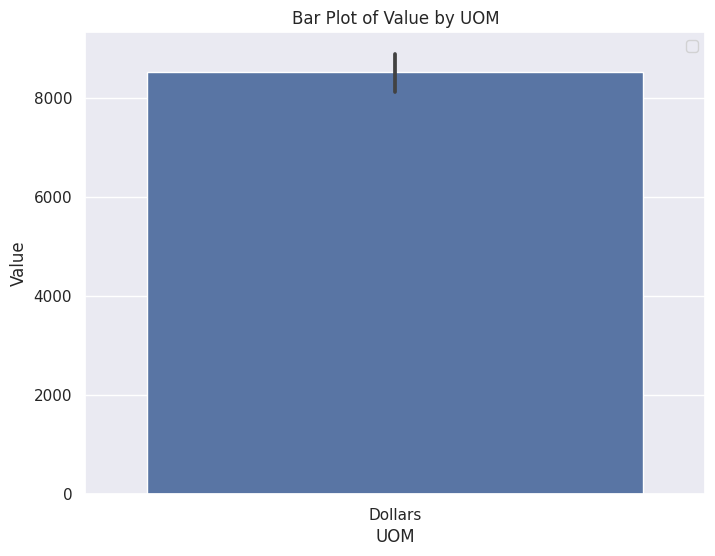

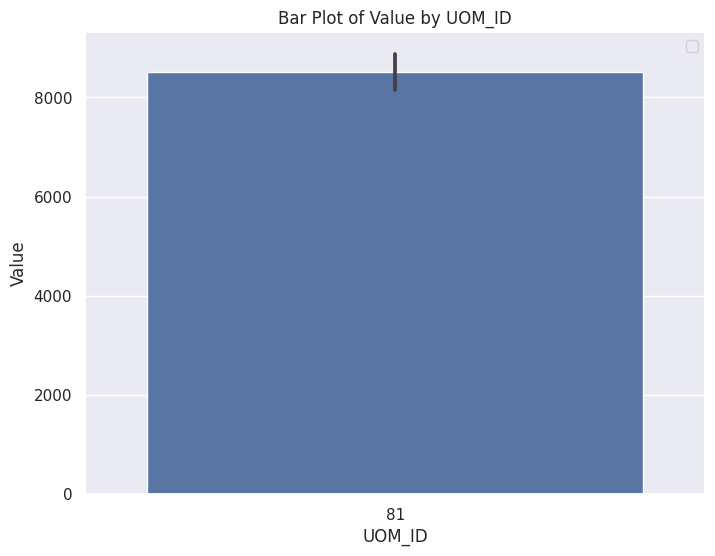

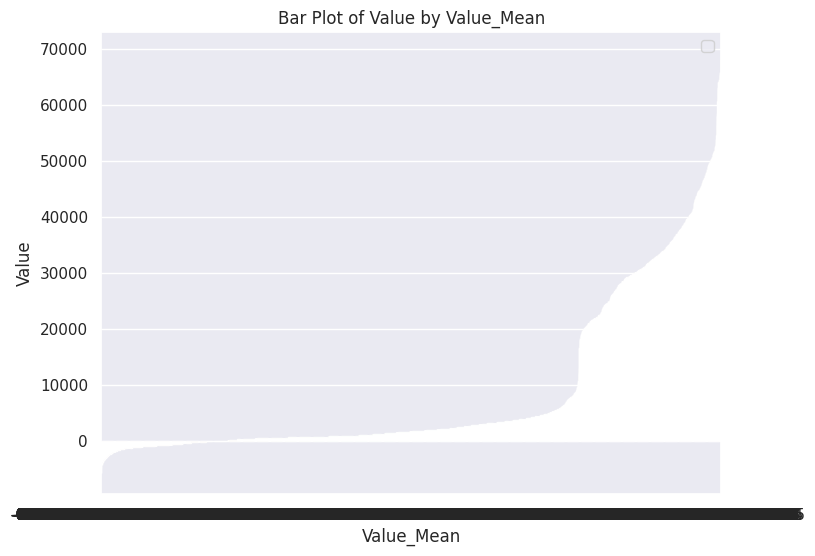

In [19]:
for column in test1.columns:
    if column != 'VALUE':
        plt.figure(figsize=(8, 6))
        sns.barplot(data=test1.reset_index(), x=column, y="VALUE") #,hue='DATE_FORMATTED')
        plt.xlabel(column)
        plt.ylabel('Value')
        plt.title(f'Bar Plot of Value by {column}')
        plt.legend()
        plt.show()

**Dropping columns not deemed neccesary for my Time series model**

In [20]:
test1.drop(['Seasonal adjustment', 'UOM', 'UOM_ID','Value_Mean'], axis= 1, inplace = True)

In [21]:
test1.columns

Index(['Trade', 'Principal trading partners', 'VALUE'], dtype='object')

Inizialiting a dataframe for encoded values in my data .

This will allow the model to read and process the information , I decided to go for a Label encoder from Sklearn as opposed to the onehotencoder since it keeps consistency of the paramenter passed into the model , 2 columns as opposed to several depending on the categories of each parameter.

In [22]:
encoded_df = test1

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test1[['Trade']])
encoded_df['Trade'] = le.transform(test1['Trade']) + 1

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test1[['Principal trading partners']])
encoded_df['Principal trading partners'] = le.transform(test1['Principal trading partners']) + 1

encoded_df

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Trade,Principal trading partners,VALUE
DATE_FORMATTED,,,
1997-01-01,2,1,21837.7
1997-02-01,2,1,21755.0
1997-03-01,2,1,21839.5
1997-04-01,2,1,22620.9
1997-05-01,2,1,22747.5
...,...,...,...
2023-02-01,3,4,-1386.8
2023-03-01,3,4,-1471.1
2023-04-01,3,4,-1515.2


The below correlation heatmap is a great tool to vizualize the correlation between my parameters and determine if they are of significance to proceed with any model. 

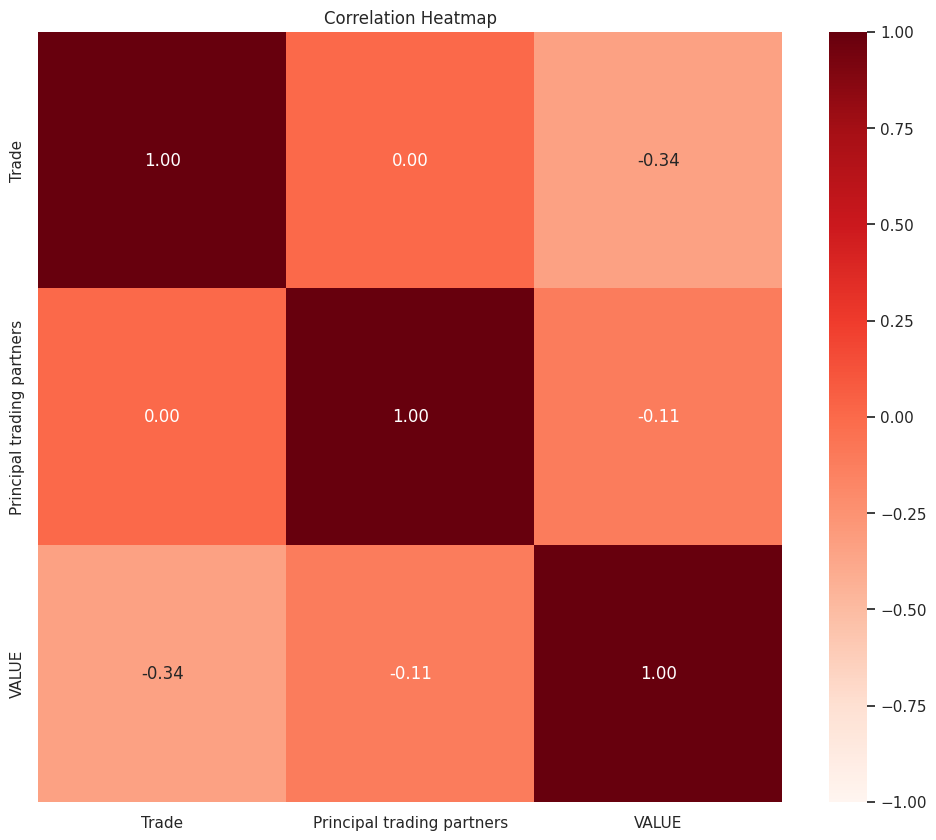

In [25]:
# Calculate the correlation matrix
correlation_matrix = encoded_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True,  fmt=".2f", cmap=plt.cm.Reds, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [26]:
encoded_df ['Date'] = encoded_df.index
encoded_df

,Trade,Principal trading partners,VALUE,Date
DATE_FORMATTED,,,,
1997-01-01,2,1,21837.7,1997-01-01
1997-02-01,2,1,21755.0,1997-02-01
1997-03-01,2,1,21839.5,1997-03-01
1997-04-01,2,1,22620.9,1997-04-01
1997-05-01,2,1,22747.5,1997-05-01
...,...,...,...,...
2023-02-01,3,4,-1386.8,2023-02-01
2023-03-01,3,4,-1471.1,2023-03-01
2023-04-01,3,4,-1515.2,2023-04-01


**Scaling VALUE column values**

In [27]:
min_value = min (encoded_df ['VALUE'])
max_value = max( encoded_df ['VALUE'] )

encoded_df['VALUE_Mean'] = (encoded_df ['VALUE'] - min_value) / (max_value - min_value)
encoded_df

,Trade,Principal trading partners,VALUE,Date,VALUE_Mean
DATE_FORMATTED,,,,,
1997-01-01,2,1,21837.7,1997-01-01,0.368269
1997-02-01,2,1,21755.0,1997-02-01,0.367166
1997-03-01,2,1,21839.5,1997-03-01,0.368293
1997-04-01,2,1,22620.9,1997-04-01,0.378713
1997-05-01,2,1,22747.5,1997-05-01,0.380401
...,...,...,...,...,...
2023-02-01,3,4,-1386.8,2023-02-01,0.058574
2023-03-01,3,4,-1471.1,2023-03-01,0.057450
2023-04-01,3,4,-1515.2,2023-04-01,0.056862


In [64]:
print(max_value)
print(min_value)

69212.3
-5779.4


**vizualizing prior to resampling , is my data stable?**

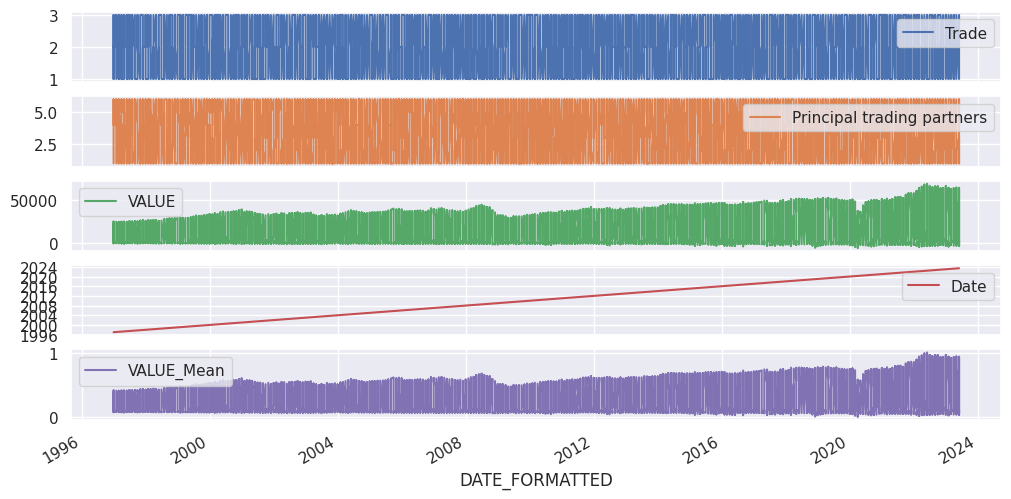

In [28]:
encoded_df.plot(figsize=(12,6), subplots = True);

**checking for null values:**

In [29]:
print ("\nMissing values :  ", encoded_df.isnull().any())


Missing values :   Trade                         False
Principal trading partners    False
VALUE                         False
Date                          False
VALUE_Mean                    False
dtype: bool


**Plottting resampled data**

<ipython-input-30-a403844c03ba>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  encoded_df.resample('M').mean().plot(subplots=True);


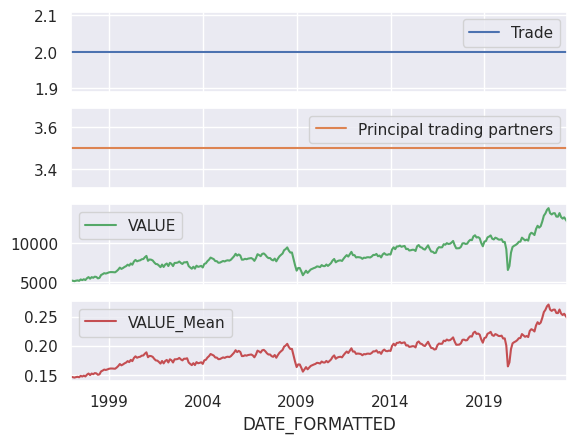

In [30]:
encoded_df.resample('M').mean().plot(subplots=True);

**Two functions to help better interpret ADF and KPSS results (via Statsmodels Documentation)**

In [31]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    print('\n')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print('\n')

    if dfoutput['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has unit root and is non-stationary')

##############################################################
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    print('\n')
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    print('\n')

    if kpss_output['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has unit root and is non-stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has no unit root & is stationary')

In [32]:
#Testing if m
print(adf_test(encoded_df['VALUE_Mean']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(encoded_df['VALUE_Mean']))

Results of Dickey-Fuller Test:


Test Statistic                   -2.708216
p-value                           0.072627
#Lags Used                       30.000000
Number of Observations Used    5693.000000
Critical Value (1%)              -3.431499
Critical Value (5%)              -2.862048
Critical Value (10%)             -2.567040
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic            3.61442
p-value                   0.01000
Lags Used                44.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has unit root and is non-stationary
None


<ipython-input-31-adf28580cd58>:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [33]:
# Using Statsmodels' built-in function:
from statsmodels.tsa.statespace.tools import diff

test1_diff = diff(encoded_df,k_diff=2) # Second-order differencing to make series stationary

test1_diff

,Trade,Principal trading partners,VALUE,Date,VALUE_Mean
DATE_FORMATTED,,,,,
1997-03-01,0.0,0.0,167.2,-3 days,0.002230
1997-04-01,0.0,0.0,696.9,3 days,0.009293
1997-05-01,0.0,0.0,-654.8,-1 days,-0.008732
1997-06-01,0.0,0.0,8.4,1 days,0.000112
1997-07-01,0.0,0.0,449.8,-1 days,0.005998
...,...,...,...,...,...
2023-02-01,0.0,0.0,920.0,0 days,0.012268
2023-03-01,0.0,0.0,-296.8,-3 days,-0.003958
2023-04-01,0.0,0.0,40.2,3 days,0.000536


In [34]:
print(adf_test(test1_diff['VALUE_Mean']))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(kpss_test(test1_diff['VALUE_Mean']))

Results of Dickey-Fuller Test:


Test Statistic                  -21.367838
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5687.000000
Critical Value (1%)              -3.431500
Critical Value (5%)              -2.862048
Critical Value (10%)             -2.567041
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
None
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic             0.018421
p-value                    0.100000
Lags Used                212.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary
None


<ipython-input-31-adf28580cd58>:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
plot_acf(encoded_df['VALUE_Mean']);

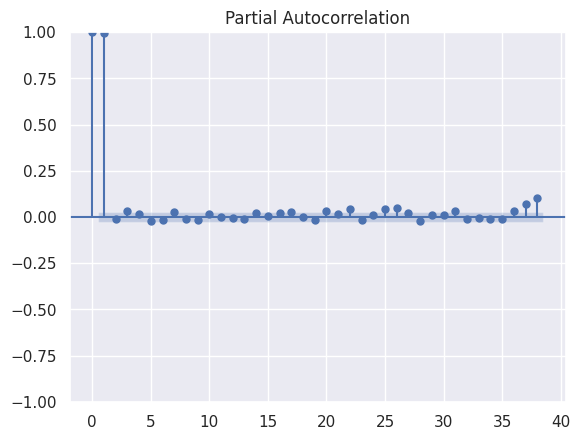

In [36]:
plot_pacf(encoded_df['VALUE_Mean']);

## Auto Arima Model

In [37]:
from pmdarima import auto_arima

encoded_df['Date_'] = np.arange(X.shape[0])
y = encoded_df['VALUE_Mean']
X = encoded_df.drop(['VALUE_Mean', 'VALUE', 'Date'], axis=1)



model_arima = pm.arima.auto_arima(y, X, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None,
                          start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False,
                          alpha=0.05, test='kpss', stepwise=True,
                          n_jobs=1, suppress_warnings=True, error_action='ignore', trace=True,
                          )


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-29522.035, Time=11.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29516.427, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29514.893, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29514.923, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29518.408, Time=1.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-29520.485, Time=5.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29518.627, Time=4.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-29520.675, Time=12.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-29527.269, Time=12.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-29520.332, Time=3.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-29527.618, Time=4.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-29527.233, Time=23.48 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-29525.233, Time=18.05 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-29526.750, Time=12.69 sec

In [41]:
# Extract date components
encoded_df['Year'] = encoded_df.index.year
encoded_df['Month'] = encoded_df.index.month
encoded_df

,Trade,Principal trading partners,VALUE,Date,VALUE_Mean,Year,Month
DATE_FORMATTED,,,,,,,
1997-01-01,2,1,21837.7,1997-01-01,0.368269,1997,1
1997-02-01,2,1,21755.0,1997-02-01,0.367166,1997,2
1997-03-01,2,1,21839.5,1997-03-01,0.368293,1997,3
1997-04-01,2,1,22620.9,1997-04-01,0.378713,1997,4
1997-05-01,2,1,22747.5,1997-05-01,0.380401,1997,5
...,...,...,...,...,...,...,...
2023-02-01,3,4,-1386.8,2023-02-01,0.058574,2023,2
2023-03-01,3,4,-1471.1,2023-03-01,0.057450,2023,3
2023-04-01,3,4,-1515.2,2023-04-01,0.056862,2023,4


#### Splitting the time series dataset

In [42]:
train = encoded_df.loc['1997-01-01':'2022-06-30']
test = encoded_df.loc['2022-07-01':]

X_train= train [['Trade','Principal trading partners','Year','Month']]
y_train= train ['VALUE_Mean']
X_test= test [['Trade','Principal trading partners','Year','Month']]
y_test= test ['VALUE_Mean']

#fitting our model
model_arima.fit(y = y_train, x = X_train)

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [43]:
# Forcasting shortcut - Using auto_arima:

Forecast = model_arima.predict(n_periods=216).rename('Auto ARIMA Forecast') # Predict for 12 periods
Forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


5508    0.061893
5509    0.062037
5510    0.062046
5511    0.062082
5512    0.062191
          ...   
5719    0.062596
5720    0.062596
5721    0.062596
5722    0.062596
5723    0.062596
Name: Auto ARIMA Forecast, Length: 216, dtype: float64

      VALUE_Mean
5508    0.941001
5509    0.948108
5510    0.948982
5511    0.951707
5512    0.930254
...          ...
5719    0.058574
5720    0.057450
5721    0.056862
5722    0.057102
5723    0.057837

[216 rows x 1 columns]
5508    0.061893
5509    0.062037
5510    0.062046
5511    0.062082
5512    0.062191
          ...   
5719    0.062596
5720    0.062596
5721    0.062596
5722    0.062596
5723    0.062596
Name: Auto ARIMA Forecast, Length: 216, dtype: float64


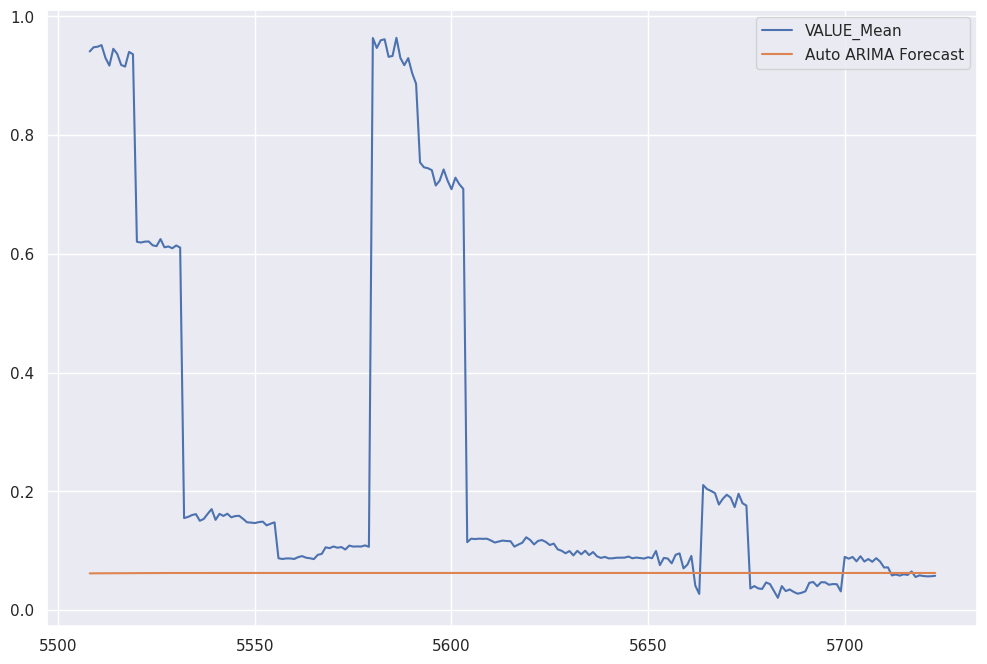

In [44]:
y_test_arima = y_test.reset_index()
y_test_arima.index +=5508
y_test_arima.drop("DATE_FORMATTED", axis = 1, inplace = True)
#y_test_arima.drop("index", axis = 1, inplace = True)
print (y_test_arima)
print (Forecast)
y_test_arima.plot(figsize=(12,8), legend=True)
Forecast.plot(legend=True);

... Not looking very good

#### Auto_Arima Model Evaluation:

In [45]:
from statsmodels.tools.eval_measures import rmse

rmse_value = rmse(y_test_arima['VALUE_Mean'], Forecast)
mean_value = y_test_arima['VALUE_Mean'].mean()

print("RMSE:", rmse_value)
print("Mean:", mean_value)

RMSE: 0.3592936929881101
Mean: 0.2566956607395416


In [46]:
# We can also compare the mean values for our predictions 
# and mean values for the test set to see how we are doing

print(f'Test Mean: {y_test_arima.mean()}')
print(f'Prediction Mean: {Forecast.mean()}')

Test Mean: VALUE_Mean    0.256696
dtype: float64
Prediction Mean: 0.06257165570328009


####  Saving our Auto Arima model

In [47]:
import pickle

file_name = 'Auto_Arima_model'

with open(file_name, 'wb') as file:
    pickle.dump(model_arima,file)

Overall our Auto Arima did not perform good as it seems it is not considering other parameters passed. It only lookes at times/dates without including relashiopships between the desired value to predict and other factors that may influence it.  

Next up, will try a LSTM model to see if any improvements can be made. 

## LSTM Multi Variate Model
LSTMs are particularly suited for sequences where previous data points have a significant influence on future ones, which is often the case with trade volumes.


Epoch 1/2000
77/77 - 5s - loss: 0.1939 - val_loss: 0.2020 - 5s/epoch - 59ms/step
Epoch 2/2000
77/77 - 0s - loss: 0.1522 - val_loss: 0.1806 - 433ms/epoch - 6ms/step
Epoch 3/2000
77/77 - 0s - loss: 0.1697 - val_loss: 0.1800 - 470ms/epoch - 6ms/step
Epoch 4/2000
77/77 - 0s - loss: 0.1628 - val_loss: 0.1801 - 400ms/epoch - 5ms/step
Epoch 5/2000
77/77 - 0s - loss: 0.1568 - val_loss: 0.1806 - 382ms/epoch - 5ms/step
Epoch 6/2000
77/77 - 1s - loss: 0.1450 - val_loss: 0.1791 - 605ms/epoch - 8ms/step
Epoch 7/2000
77/77 - 1s - loss: 0.1425 - val_loss: 0.1794 - 736ms/epoch - 10ms/step
Epoch 8/2000
77/77 - 1s - loss: 0.1382 - val_loss: 0.1791 - 1s/epoch - 13ms/step
Epoch 9/2000
77/77 - 1s - loss: 0.1526 - val_loss: 0.1822 - 569ms/epoch - 7ms/step
Epoch 10/2000
77/77 - 1s - loss: 0.1473 - val_loss: 0.1810 - 631ms/epoch - 8ms/step
Epoch 11/2000
77/77 - 0s - loss: 0.1451 - val_loss: 0.1836 - 487ms/epoch - 6ms/step
Epoch 12/2000
77/77 - 1s - loss: 0.1442 - val_loss: 0.1801 - 587ms/epoch - 8ms/step
Epoc

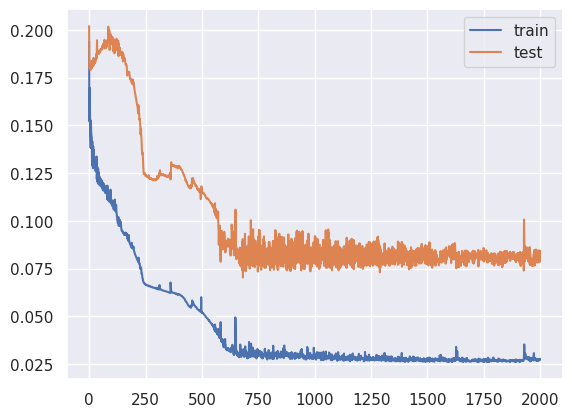

In [49]:
from keras.layers import LSTM
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as pyplot

# design network
model_lstm2  = Sequential()
model_lstm2.add(LSTM(50, input_shape=(4,1)))
model_lstm2.add(Dense(1))
model_lstm2.compile(loss='mae', optimizer='adam')
# fit network
history = model_lstm2.fit(X_train , y_train, epochs=2000, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make a prediction

In [50]:
yhat = model_lstm2.predict(X_test)
test_X = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

7/7 [==============================] - 0s 2ms/step


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test.iloc[:, :-1]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

In [55]:
# Invert scaling for actual
inv_y = np.concatenate((y_test.values.reshape(-1, 1), X_test.iloc[:, -1].values.reshape(-1, 1)), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_y)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

from sklearn.metrics import mean_squared_error
import math

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.130


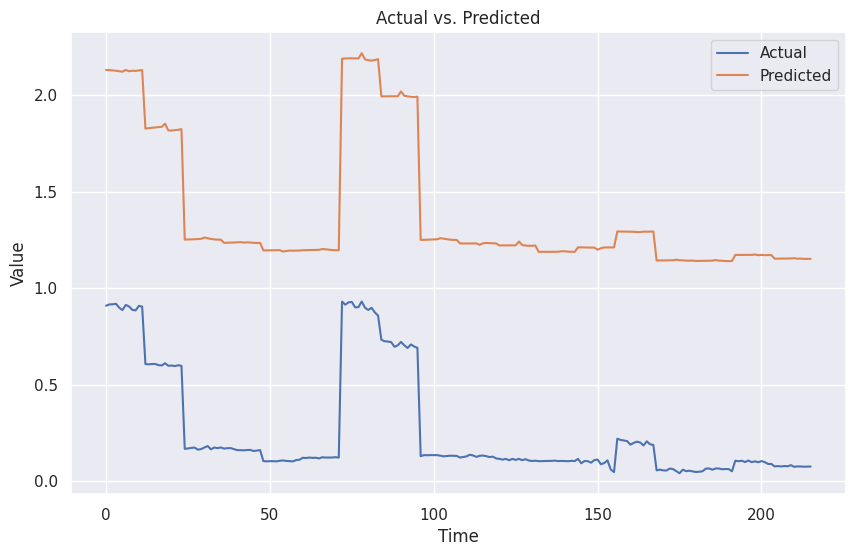

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(inv_y, label='Actual')
plt.plot(inv_yhat, label='Predicted')
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import tensorflow as tf
from keras.models import load_model

model_lstm2.save('content/drive/LSTM_keras_model2.h5')


**Let's talk about this LSTM Model..**

The model's ability to capture the complex relationships in the data was crucial in achieving accurate predictions.

The architecture of my LSTM model is quite straightforward. It consists of one LSTM layer with 50 hidden units followed by a Dense layer with one output unit. This configuration allows the model to learn and understand patterns in the data, making it well-suited for time series forecasting.

**Training and Optimization**
To train the model, I used the Adam optimizer and chose the Mean Absolute Error (MAE) loss function. I trained the model for 2000 epochs with a batch size of 72. This approach allowed the model to learn and adjust its weights over multiple iterations.

**Training Progress**
As I trained the model, I closely monitored its performance. By plotting the training loss and the validation loss over epochs, I was able to observe how well the model was learning and whether it was overfitting or underfitting the data.

**How to Improve?**
While the model yielded good results, there's always room for improvement. In the future, I could explore hyperparameter tuning to fine-tune the model's architecture and optimize its performance even further. Incorporating external factors or additional data sources could also enhance the model's predictive capabilities. Also the increase of epochs and batch sized could be beneficial for this model. 

#### It's important to highlight why the LSTM model excelled over the Auto ARIMA model. While both methods have their strengths, the LSTM's capacity to learn from intricate patterns and relationships in the data gives it an edge. In comparison, the Auto ARIMA model, although effective, might struggle to capture the non-linear and long-range dependencies present in time series data.

## Flask Deployment

from flask import Flask, render_template, request, redirect, url_for
import pickle
import json
import numpy as np
from keras.models import Sequential
import keras.models
import tensorflow

app = Flask(__name__ , template_folder= 'templates')

model_lstm2 = pickle.load(open('LSTM_multivar_model', 'rb'))

@app.route('/')
def temp():
    return render_template('index.html')

@app.route('/predict',methods=['POST'])
def predict():

    int_features = [int(x) for x in request.form.values()]
    final_features = [np.array(int_features)]
    prediction = model.predict(final_features)

    output = round(prediction[0], 2)

    return render_temp
@app.route('/run_pred/<values>')
def run_pred(values):
    import numpy as np 
    print(values)
    #values = values.split(',')
    #values = np.array(values).astype('float')
    #values = values.reshape(1,-1)
    values = values['mytext']
    
    with open('../timeseries_model', 'rb') as file:
        pickle_model = pickle.load(file)
        
    model = pickle_model
    pred = model.predict(values)
    probability = model.predict_proba(values)

    json_object =  {'predicted': pred, 'probability': probability}

    if pred == 0:
        return jsonify(json_object)
    return jsonify(json_object)
    
if __name__ == '__main__':
    app.run(host='127.0.0.1', port=5100, debug=True, threaded=True)

## To test the deployment run the below code:
    
url = "http://127.0.0.1:5100/predict"
array = '{"data": [0,0,1997,3]}'
data  = json.loads(array)
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)
r.json()

Leyend :

**Trade** 
Export = 1
Import = 2
Trade Balance = 3

**Principal Trade Partners** 
All countries = 1
China = 2
European Union = 3
Mexico = 4
United Kingdom = 5
United States = 6

**Year** 

**Month**

[1,2,2030,3]